# Make sure that you are using the same version of python and sklearn for compatibility

In [1]:
from platform import python_version
print(python_version())
import sklearn
print((sklearn.__version__) )

3.9.13
1.2.1


In [3]:
import sys
required_version = (3, 9, 0)  # The minimum required Python version
if sys.version_info < required_version:
    raise ValueError(f"Python version {required_version[0]}.{required_version[1]} or higher is required, but current version is {sys.version_info[0]}.{sys.version_info[1]}")
else:
    print('The minimum required Python version is satisfied!')

required_version_sklearn = (1, 2, 1)  # The minimum required sklearn version
your_sklearn_version = (int(sklearn.__version__[0]),int(sklearn.__version__[2]),int(sklearn.__version__[4]))
if your_sklearn_version < required_version_sklearn:
    raise ValueError(f"Sklearn version {required_version_sklearn[0]}.{required_version_sklearn[1]} or higher is required, but current version is {your_sklearn_version[0]}.{your_sklearn_version[1]}")
else:
    print('The minimum required sklearn version is satisfied!')

The minimum required Python version is satisfied!
The minimum required sklearn version is satisfied!


In [2]:
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pickle
import requests
import joblib

## Load the saved models

first dowonload the saved models in pickle format from gitub (.joblib files)
* https://github.com/farhadseda/Ensemble-Region-Specific-GMMs-for-Subduction-Earthquakes

In [4]:
# load the model from disk
ANN = joblib.load("./ANN.joblib")  
KRR = joblib.load("./KRR.joblib")
RFR = joblib.load("./RFR.joblib")
SVR = joblib.load("./SVR.joblib")

In [7]:
ANN

MultiOutputRegressor(estimator=Pipeline(steps=[('columntransformer-1',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('functiontransformer',
                                                                                 FunctionTransformer(feature_names_out='one-to-one',
                                                                                                     func=<ufunc 'log'>),
                                                                                 ['ClstD_km',
                                                                                  'Vs30_Selected_for_Analysis_m_s'])],
                                                                  verbose_feature_names_out=False)),
                                               ('columntransformer-2',
                                                ColumnTransformer(transfor...
                                                                                 ['Earthquake_Magnitude',
                                                                                  'ClstD_km',
                                                                                  'Ztor_km',
                                                                                  'Vs30_Selected_for_Analysis_m_s']),
                                                                                ('onehotencoder',
                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                 ['Tectonic',
                                                                                  'DatabaseRegion'])],
                                                                  verbose_feature_names_out=False)),
                                               ('mlpregressor',
                                                MLPRegressor(alpha=0.1,
                                                             batch_size=64,
                                                             early_stopping=True,
                                                             hidden_layer_sizes=(16,
                                                                                 8),
                                                             max_iter=500,
                                                             random_state=42,
                                                             tol=1e-05))]),
                     n_jobs=-4)

## Function to plot the distance scaling

In [8]:
# plot distance scaling
def plot_dist_scaling(df_plot, predicted):
    # plt.figure(figsize = (8,7))
    color = ['purple','blue','green','yellow','red']
    styles = ['-','--','-.','-','--']
    d = list(set(df_plot['ClstD_km'].tolist()))
    d.sort()
    for m, j,style in zip(df_plot.Earthquake_Magnitude.unique(),color, styles):
        plt.loglog(d, np.exp(predicted[df_plot.Earthquake_Magnitude == m]), style, linewidth=3, color = j, label = 'M'+str(m))
       
    plt.legend(loc = 'lower left')
    plt.xlabel('Rupture Distance (km)')
    plt.ylabel('Acceleration (g)')
    plt.ylim([0.000001, 10])
    plt.xlim([10, 1000])

## Function to create the dataframe for prediction

In [35]:
# function to create the data needed for plotting
# regions: Global, Alaska, Japan, Cascadia, Taiwan, CentralAmerica&Mexico, SouthAmerica
# tectonic: Interface or Intraslab
def data_for_plot(Vs: list, Ztor: list, tectonic = 'Interface', region = 'Global'):
    # M = list(np.linspace(5,8.5,8))
    M = list(np.arange(5,10,1))
    if tectonic == 'Intraslab':
        M = list(np.arange(5,9,1))
    min_dist = int(max(20, np.array(Ztor)))
    d = list(range(min_dist,1000,5))
    List = [M, d, Ztor, Vs]
    

    combination = [p for p in itertools.product(*List)]

    df = pd.DataFrame(combination, columns =
                      ['Earthquake_Magnitude', 'ClstD_km', 'Ztor_km','Vs30_Selected_for_Analysis_m_s'],
                                               dtype = float) 
    df['Tectonic'] = tectonic
    df['DatabaseRegion'] = region
    return df

## Periods and weights of each individual model

In [15]:
# required columns from the processed data
# to retriev PGA use column 0, to retrive PSA0.01 s use column 1 and so on.
# Thus PSA0.2 is column 8
# PSA1.0 s would be columns 14
periods = ['PGA_g','T0pt010S','T0pt020S','T0pt030S','T0pt050S','T0pt075S','T0pt100S','T0pt150S',
          'T0pt200S','T0pt250S','T0pt300S', 'T0pt400S','T0pt500S','T0pt750S','T1pt000S',
          'T1pt500S','T2pt000S','T3pt000S','T4pt000S','T5pt000S','T7pt500S','T10pt000S',
          'PGV_cm_sec','PGD_cm']

# to plot response spectra
T = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7.5, 10]

# wieght to combine different schemes: w0: RF, w1: NN, w2: KR, w3: SVR
# you can adjust/change the weight to see effect of different combinations
w = [0.25, 0.25, 0.25, 0.25]    

For region you can select between
* Global
* Alaska
* Cascadia
* CentralAmerica&Mexico
* Japan
* SouthAmerica
* Taiwan

# Prediction for interface events for a global version with VS30 = 400 m/s and Ztor = 10 km for PGA and PSA at 0.2 s

In [25]:
t0 = time.time()
df_plot = data_for_plot(Vs=[400], Ztor=[10], tectonic='Interface', region = 'Global')
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 12.56 s


Text(0.5, 1.0, 'PSA at 0.2 s - Interface - Global')

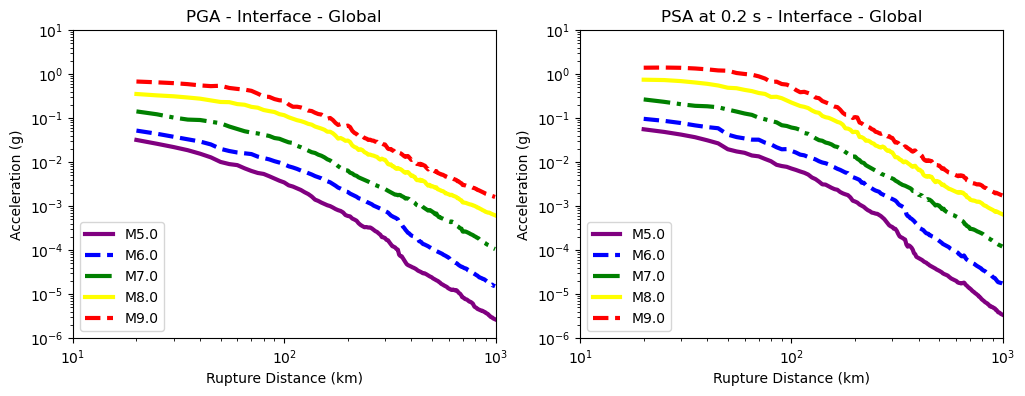

In [26]:
plt.figure(figsize = (12, 4))
# PGA is column 0
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA - Interface - Global')
# PSA0.2 is column 8
plt.subplot(1,2,2)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,8])
plt.title('PSA at 0.2 s - Interface - Global')

# Prediction for intraslab events for Japan with VS30 = 760 m/s and Ztor = 20 km for PGA and PSA at 1.0 s

In [27]:
t0 = time.time()
df_plot = data_for_plot(Vs=[760], Ztor=[20], tectonic='Intraslab', region = 'Japan')
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 7.76 s


Text(0.5, 1.0, 'PSA at 1.0 s - Intraslab - Japan')

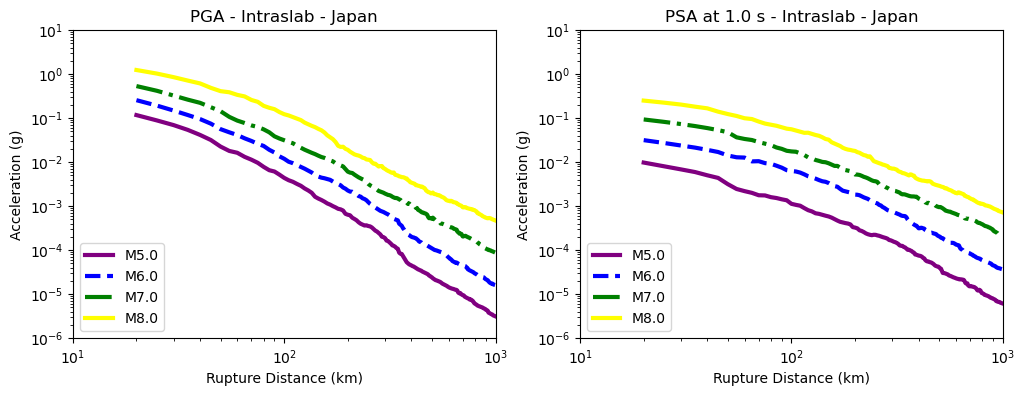

In [28]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA - Intraslab - Japan')
plt.subplot(1,2,2)
# PSA1 is column 14
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,14])
plt.title('PSA at 1.0 s - Intraslab - Japan')

# Prediction for intraslab events for Taiwan with VS30 = 200 m/s and Ztor = 50 km for PGA and PSA at 0.2 s

In [36]:
t0 = time.time()
df_plot = data_for_plot(Vs=[200], Ztor=[50], tectonic='Intraslab', region = 'Taiwan')
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 7.94 s


Text(0.5, 1.0, 'PSA at 0.2 s - Intraslab - Taiwan')

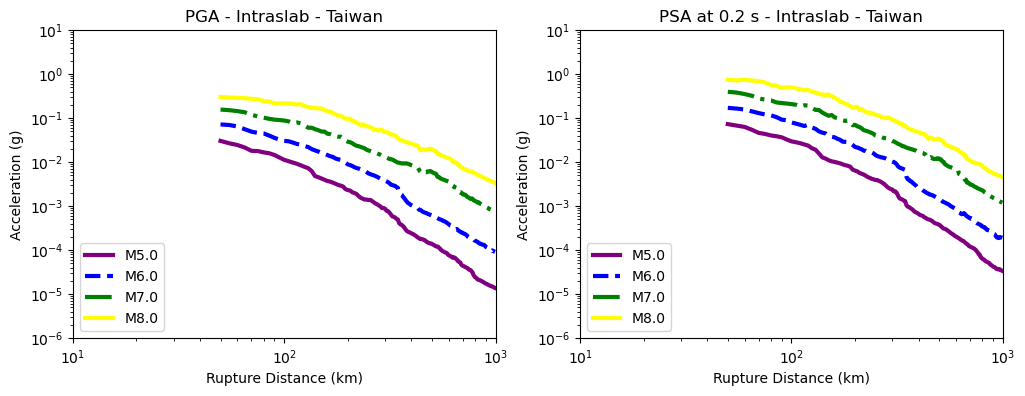

In [37]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA - Intraslab - Taiwan')
plt.subplot(1,2,2)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,8])
plt.title('PSA at 0.2 s - Intraslab - Taiwan')

### To see the predicted data in ln format

In [38]:
df_plot_predict_ensemble.head()

,PGA_g,T0pt010S,T0pt020S,T0pt030S,T0pt050S,T0pt075S,T0pt100S,T0pt150S,T0pt200S,T0pt250S,...,T1pt000S,T1pt500S,T2pt000S,T3pt000S,T4pt000S,T5pt000S,T7pt500S,T10pt000S,PGV_cm_sec,PGD_cm
0,-3.494841,-3.501277,-3.471976,-3.431347,-3.333160,-3.104676,-2.895438,-2.691483,-2.616475,-2.618394,...,-3.951366,-4.904770,-5.546343,-6.591605,-7.234863,-7.786178,-8.639509,-9.245550,0.737488,-1.412055
1,-3.619484,-3.618498,-3.588229,-3.563535,-3.481039,-3.258925,-3.068650,-2.793369,-2.694973,-2.722162,...,-4.050153,-4.982556,-5.653249,-6.687181,-7.339269,-7.890255,-8.748925,-9.364786,0.629706,-1.528730
2,-3.707099,-3.698312,-3.669110,-3.655041,-3.561950,-3.338039,-3.125607,-2.859006,-2.762507,-2.814401,...,-4.183410,-5.071778,-5.750780,-6.771734,-7.425493,-7.985498,-8.845586,-9.470898,0.537135,-1.636843
3,-3.839203,-3.832560,-3.805809,-3.788919,-3.691018,-3.481593,-3.284589,-3.005343,-2.913851,-2.988469,...,-4.293523,-5.229817,-5.877126,-6.868800,-7.521478,-8.096644,-8.964749,-9.590845,0.434312,-1.764926
4,-4.013835,-4.014209,-3.974970,-3.967839,-3.825297,-3.558736,-3.346888,-3.123873,-3.074586,-3.114011,...,-4.494651,-5.399111,-6.095110,-7.059804,-7.711611,-8.319938,-9.204155,-9.846556,0.262419,-2.017566


### To see the predicted data in g or cm/s

In [39]:
np.exp(df_plot_predict_ensemble.tail())

,PGA_g,T0pt010S,T0pt020S,T0pt030S,T0pt050S,T0pt075S,T0pt100S,T0pt150S,T0pt200S,T0pt250S,...,T1pt000S,T1pt500S,T2pt000S,T3pt000S,T4pt000S,T5pt000S,T7pt500S,T10pt000S,PGV_cm_sec,PGD_cm
755,0.003527,0.003592,0.003888,0.003906,0.003981,0.004968,0.005852,0.005117,0.004787,0.005783,...,0.002686,0.003013,0.002403,0.002207,0.000937,0.001061,0.000953,0.000434,0.824685,0.699281
756,0.003494,0.003558,0.003852,0.003870,0.003942,0.004922,0.005795,0.005065,0.004740,0.005727,...,0.002665,0.002988,0.002387,0.002195,0.000932,0.001055,0.000948,0.000432,0.819122,0.696045
757,0.003439,0.003502,0.003791,0.003812,0.003862,0.004876,0.005740,0.005013,0.004694,0.005672,...,0.002632,0.002964,0.002372,0.002183,0.000927,0.001049,0.000943,0.000430,0.813625,0.692844
758,0.003408,0.003470,0.003756,0.003777,0.003824,0.004832,0.005685,0.004963,0.004648,0.005618,...,0.002611,0.002940,0.002357,0.002172,0.000922,0.001043,0.000939,0.000428,0.808192,0.689675
759,0.003377,0.003438,0.003721,0.003743,0.003787,0.004788,0.005631,0.004913,0.004603,0.005564,...,0.002587,0.002916,0.002342,0.002160,0.000917,0.001038,0.000934,0.000426,0.802822,0.686540


### Plotting each inividual ML models abd the ensemble

In [44]:
# if you want to see for different Vs30 and Ztor you should run below otherwise skip it
df_plot = data_for_plot(Vs=[400], Ztor=[30], tectonic='Interface', region = 'Global')
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

(10, 1000)

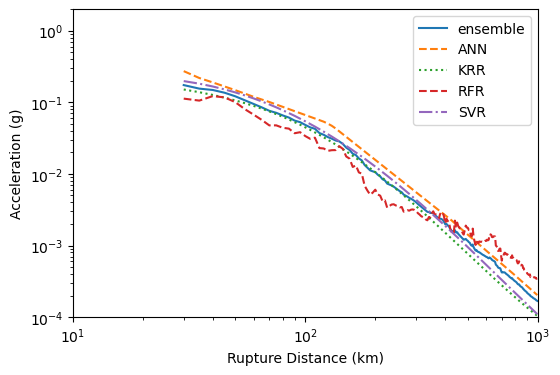

In [45]:
# define the magnitude and period that you are interested in
mag = 7
T_period = 0

ML = plt.figure(figsize = (6,4))
d = list(set(df_plot['ClstD_km'].tolist()))
d.sort()
idx = df_plot[df_plot.Earthquake_Magnitude == mag].index.to_list()
plt.loglog(d, np.exp(df_plot_predict_ensemble.iloc[idx,T_period]),label = 'ensemble')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_ANN).iloc[idx,T_period]),'--',label = 'ANN')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_KRR).iloc[idx,T_period]),':',label = 'KRR')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_RFR).iloc[idx,T_period]),'--',label = 'RFR')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_SVR).iloc[idx,T_period]),'-.',label = 'SVR')

plt.legend()
plt.xlabel('Rupture Distance (km)')
plt.ylabel('Acceleration (g)')
plt.ylim([0.0001, 2])
plt.xlim([10, 1000])

### Plot response spectra - M6 at 50 km

In [46]:
# if you want to see for different Vs30 and Ztor you should run below otherwise skip it
df_plot = data_for_plot(Vs=[400], Ztor=[30], tectonic='Intraslab', region = 'Global')
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

(0.01, 10)

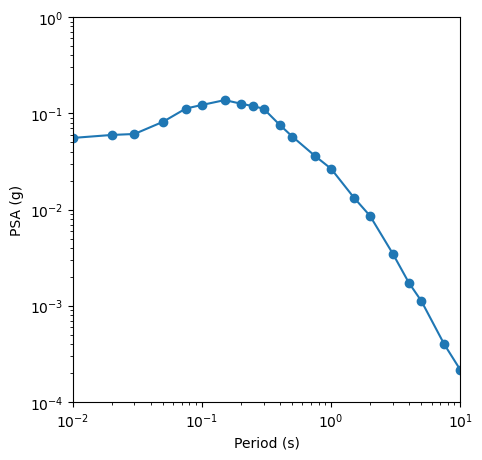

In [50]:
r = 50
mag = 6
response=plt.figure(figsize = (5,5))
plt.loglog(T,np.exp(df_plot_predict_ensemble.iloc[df_plot[(df_plot.Earthquake_Magnitude == mag) & (df_plot.ClstD_km == r)].index[0],1:22]),'o-')

plt.xlabel('Period (s)')
plt.ylabel('PSA (g)')
plt.ylim([0.0001, 1])
plt.xlim([0.01, 10])